# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

portfolio.json
id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)

profile.json
age (int) - age of the customer 
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income

transcript.json
event (str) - record description 
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score


import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


# Exploratory Data Analysis

### Portfolio

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.describe().T

,count,mean,std,min,25%,50%,75%,max
difficulty,10.0,7.7,5.831905,0.0,5.0,8.5,10.0,20.0
duration,10.0,6.5,2.321398,3.0,5.0,7.0,7.0,10.0
reward,10.0,4.2,3.583915,0.0,2.0,4.0,5.0,10.0


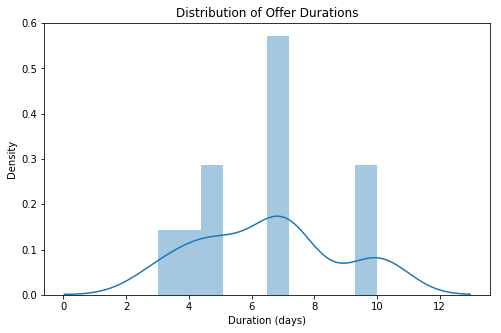

In [5]:
# Distribution of offer types

plt.figure(figsize=(8, 5))
sns.distplot(portfolio['duration'], bins=10, kde=True)
plt.title('Distribution of Offer Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Density')

plt.show()

### Profile

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


In [8]:
profile.isnull().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [9]:
def plot_distribution(data, column, xlabel):
    """
    Plot the distribution of a numerical variable.

    Parameters:
    - data (DataFrame): The DataFrame containing the data to be plotted.
    - column (str): The name of the column in the DataFrame to be plotted.
    - xlabel (str): The label for the x-axis.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 5))
    sns.distplot(data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

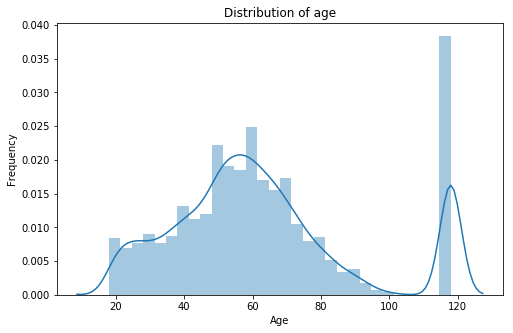

In [10]:
plot_distribution(profile, 'age', 'Age')

In [11]:
profile[profile.age==118]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


Different ID and becoming member dates and null information, so I will assume unknown age is also filled with 118 and drop (will not fill because this will make bias) values with age 118 for correct analysis and unbiased results

In [12]:
profile = profile[profile.age!=118]

In [13]:
profile.isnull().mean() #Null ratio is 0 as I dropped ages with 118

age                 0.0
became_member_on    0.0
gender              0.0
id                  0.0
income              0.0
dtype: float64

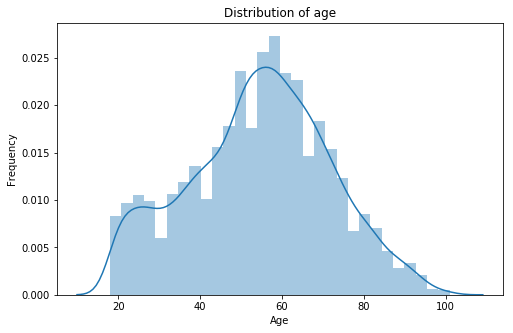

In [14]:
plot_distribution(profile, 'age', 'Age')

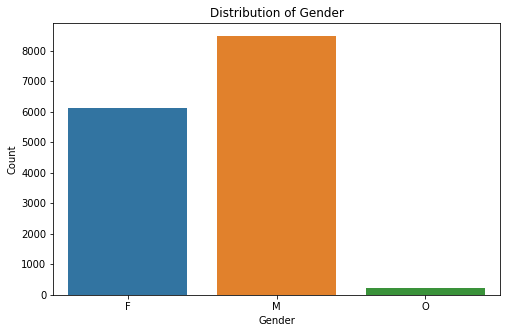

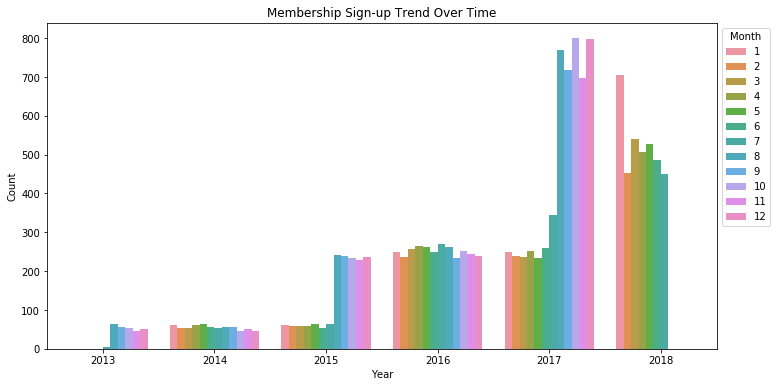

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(data=profile, x='gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

profile['membership_year'] = profile['became_member_on'].dt.year
profile['membership_month'] = profile['became_member_on'].dt.month

plt.figure(figsize=(12, 6))
sns.countplot(data=profile, x='membership_year', hue='membership_month')
plt.title('Membership Sign-up Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Month', bbox_to_anchor=(1, 1))
plt.show()


The distribution of gender shows that there are more male customers than female customers in the dataset.

The plot depicting the membership sign-up trend over time reveals that the number of sign-ups has been increasing over the years. There seems to be variability in sign-ups across different months, with some months having higher sign-up counts compared to others.

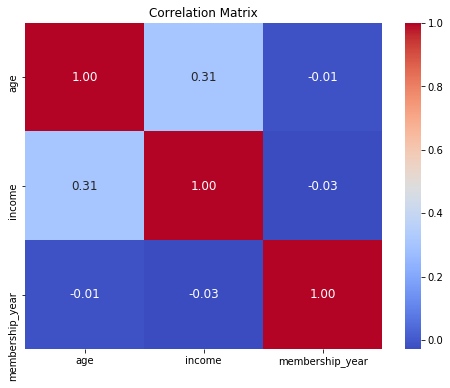

In [16]:
# Now let's take a look at correlation matrix
correlation_matrix = profile[['age', 'income', 'membership_year']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.show()


There is no significant correlation between age and membership_year, suggesting that age does not strongly influence the year in which customers sign up for membership.

Next, let's visualize the distribution of membership sign-ups across different age groups and genders. This will provide further insights into the composition of the customer base.

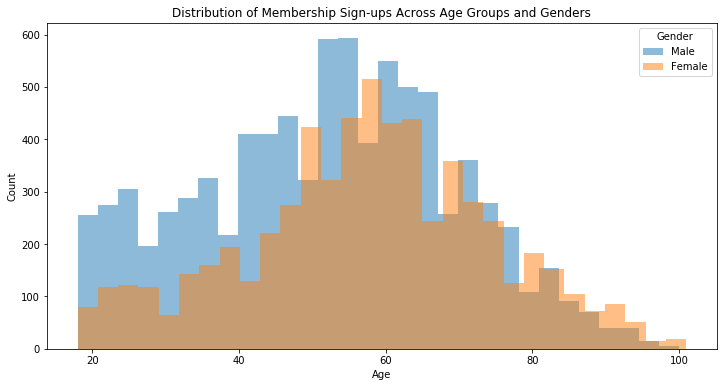

In [17]:
# Separating data by gender
male_data = profile[profile['gender'] == 'M']
female_data = profile[profile['gender'] == 'F']

plt.figure(figsize=(12, 6))

sns.distplot(male_data['age'], bins=30, hist_kws={'alpha': 0.5}, kde=False, label='Male')

sns.distplot(female_data['age'], bins=30, hist_kws={'alpha': 0.5}, kde=False, label='Female')

plt.title('Distribution of Membership Sign-ups Across Age Groups and Genders')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Gender', bbox_to_anchor=(1, 1))
plt.show()

Now let's take a look at transcript file 

In [18]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.isnull().mean() #No null values

event     0.0
person    0.0
time      0.0
value     0.0
dtype: float64

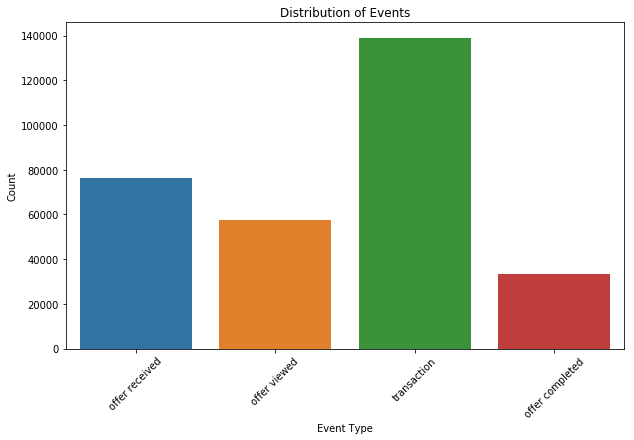

In [20]:
# Let's plot event distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=transcript, x='event')
plt.title('Distribution of Events')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


This visualization helps us understand the frequency of each type of event.

Next, let's analyze when these events tend to occur by examining the time column to see how events are distributed over time

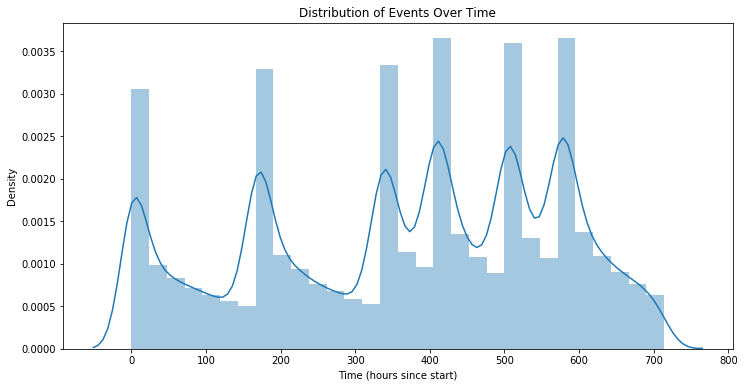

In [21]:
plt.figure(figsize=(12, 6))

sns.distplot(transcript['time'], bins=30, kde=True)

plt.title('Distribution of Events Over Time')
plt.xlabel('Time (hours since start)')
plt.ylabel('Density')

plt.show()

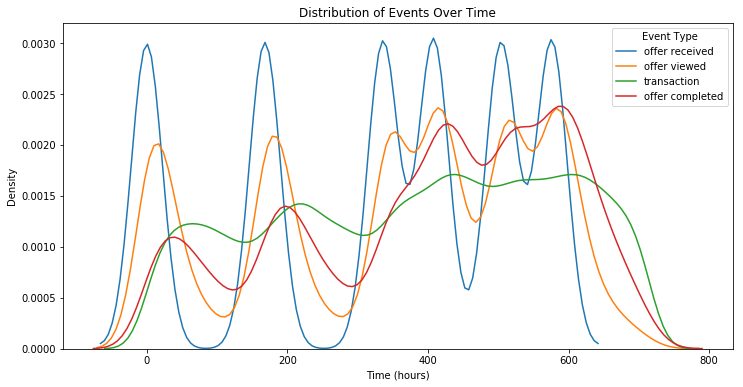

In [22]:
plt.figure(figsize=(12, 6))

event_types = transcript['event'].unique()

for event_type in event_types:
    sns.distplot(transcript[transcript['event'] == event_type]['time'], bins=50, hist=False, kde=True, label=event_type)

plt.title('Distribution of Events Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Density')
plt.legend(title='Event Type')
plt.show()

## Data Preparation

### Portfolio

I will adjust column names for explanation above (at the start of the notebook)

In [23]:
portfolio_new_names = {
                       'difficulty':'offer_difficulty',
                       'id':'offer_id', 
                       'duration':'offer_duration', 
                       'reward': 'offer_reward'}

portfolio = portfolio.rename(columns=portfolio_new_names)

In [24]:
portfolio

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [25]:
all_channels = ['web','email','mobile','social']

In [26]:
portfolio = pd.concat([pd.DataFrame({channel:[] for channel in all_channels}),portfolio],axis=1)

In [27]:
def channel_encoder(df):
    """
    Encodes channels data in the DataFrame into binary format.
    
    Args:
        df (DataFrame): The pandas DataFrame containing the channels data.

    Returns:
        DataFrame: The DataFrame with encoded channel data.

    This function iterates through each row in the DataFrame and checks whether each channel
    exists in the 'channels' column. If a channel exists, it sets the corresponding column
    in the DataFrame to '1', otherwise, it sets it to '0'. Then it drops the original 'channels'
    column and returns the modified DataFrame.
    """
    for row in range(len(df)):
        for channel in all_channels:
            if channel in df.channels[row]:
                df[channel].iloc[row] = '1'
            else:
                df[channel].iloc[row] = '0'
    df.drop('channels',axis=1,inplace=True)
    
    return df

In [28]:
portfolio = channel_encoder(portfolio)

In [29]:
portfolio

,web,email,mobile,social,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,0,1,1,1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,1,1,1,1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,1,1,1,0,0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,1,1,1,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,1,1,0,0,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,1,1,1,1,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,1,1,1,1,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,0,1,1,1,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,1,1,1,1,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,1,1,1,0,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### Profile

In [30]:
profile_new_names = {'id':'customer_id' , 'income':'customer_income'}

profile = profile.rename(columns=profile_new_names)

In [31]:
profile.head()

,age,became_member_on,gender,customer_id,customer_income,membership_year,membership_month
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11


In [32]:
profile.shape

(14825, 7)

In [33]:
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,14825.0,54.393524,17.383705,18.0,42.0,55.0,66.0,101.0
customer_income,14825.0,65404.991568,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0
membership_year,14825.0,2016.620169,1.198245,2013.0,2016.0,2017.0,2017.0,2018.0
membership_month,14825.0,6.695582,3.488853,1.0,4.0,7.0,10.0,12.0


### Transript

In [34]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
transcript_new_names = {'person':'customer_id'}

transcript = transcript.rename(columns=transcript_new_names)

In [36]:
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [37]:
distinct_keys = set()
for item in transcript.value:
    distinct_keys.update(item.keys())

print("Distinct keys in the column:")
for key in distinct_keys:
    print(key)

Distinct keys in the column:
offer id
offer_id
amount
reward


As we can see there's values like offer id and offer_id. I will categorize both of them as offer_id and create new column for each key and replace nan with 0

In [38]:
def categorize_values(df):
    """
    Clean the transcript DataFrame as per task 2.

    Parameters:
    - df: DataFrame containing transcript data.

    Returns:
    - df: Output DataFrame as per the task.
    """
    
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id') or x.get('offer id'))
    df['gained_money'] = df['value'].apply(lambda x: x.get('reward', 0))
    df['spent_money'] = df['value'].apply(lambda x: x.get('amount', 0))
    
    df.drop(columns=['value'], inplace=True)
    
    df.fillna({'offer_id_combined': 'N/A', 'gained_money': 0, 'spent_money': 0}, inplace=True)
    

    return df

In [39]:
transcript = categorize_values(transcript)

In [40]:
transcript.head(20)

,event,customer_id,time,offer_id,gained_money,spent_money
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0


## Merging dataframes

In [41]:
transcript_portfolio = pd.merge(transcript, portfolio, on='offer_id')

In [42]:
df = pd.merge(transcript_portfolio, profile, on='customer_id')

In [43]:
df.head()

,event,customer_id,time,offer_id,gained_money,spent_money,web,email,mobile,social,offer_difficulty,offer_duration,offer_type,offer_reward,age,became_member_on,gender,customer_income,membership_year,membership_month
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0,1,1,1,0,5,7,bogo,5,75,2017-05-09,F,100000.0,2017,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0,1,1,1,0,5,7,bogo,5,75,2017-05-09,F,100000.0,2017,5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0.0,1,1,1,0,5,7,bogo,5,75,2017-05-09,F,100000.0,2017,5
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,1,1,1,1,5,5,bogo,5,75,2017-05-09,F,100000.0,2017,5
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,5,0.0,1,1,1,1,5,5,bogo,5,75,2017-05-09,F,100000.0,2017,5


Now, let's see if frequency of offer types affect membership count

In [44]:
customer_count_by_year = df.groupby('membership_year')['customer_id'].nunique().reset_index(name='customer_count')

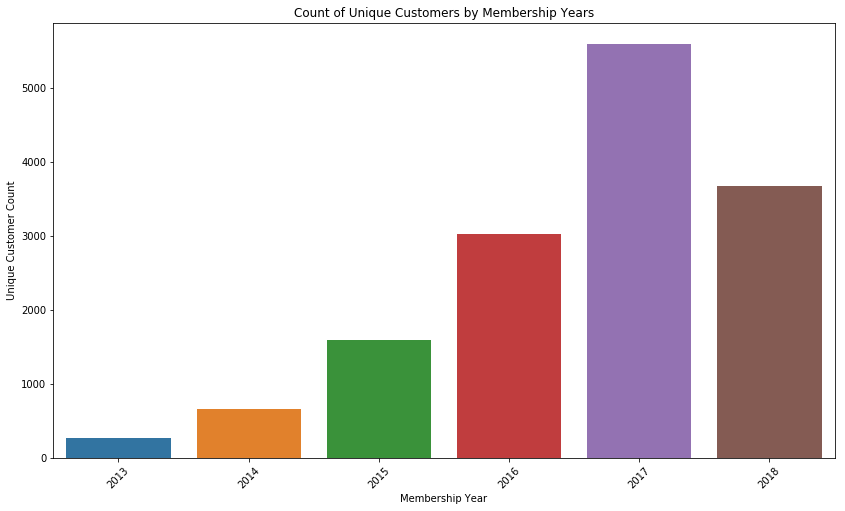

In [45]:
plt.figure(figsize=(14, 8))
sns.barplot(x='membership_year', y='customer_count', data=customer_count_by_year)
plt.title('Count of Unique Customers by Membership Years')
plt.xlabel('Membership Year')
plt.ylabel('Unique Customer Count')
plt.xticks(rotation=45)
plt.show()

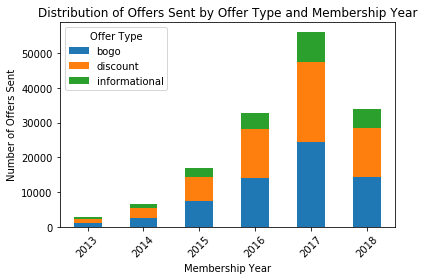

In [46]:
membership_offers_by_year = df.groupby(['membership_year', 'offer_type']).agg({
    'offer_id': 'count'
}).rename(columns={'offer_id': 'offers_sent'}).reset_index()

membership_offers_pivot = membership_offers_by_year.pivot(index='membership_year', columns='offer_type', values='offers_sent').fillna(0)

plt.figure(figsize=(14, 8))
membership_offers_pivot.plot(kind='bar', stacked=True)
plt.title('Distribution of Offers Sent by Offer Type and Membership Year')
plt.xlabel('Membership Year')
plt.ylabel('Number of Offers Sent')
plt.xticks(rotation=45)
plt.legend(title='Offer Type')
plt.tight_layout()
plt.show()

Count of BOGO and Discount offers are nearly the same, so we can't really tell the count of specific offer type increases membership

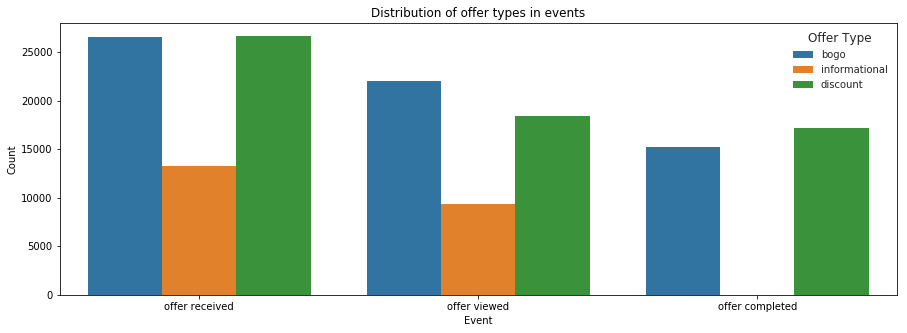

In [47]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

We can see that, although count of received bogo and discount offers are the same, people generally prefer discount offers more

# Building machine learning model

In [48]:
df.head(20)

,event,customer_id,time,offer_id,gained_money,spent_money,web,email,mobile,social,offer_difficulty,offer_duration,offer_type,offer_reward,age,became_member_on,gender,customer_income,membership_year,membership_month
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0,1,1,1,0,5,7,bogo,5,75,2017-05-09,F,100000.0,2017,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0,1,1,1,0,5,7,bogo,5,75,2017-05-09,F,100000.0,2017,5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0.0,1,1,1,0,5,7,bogo,5,75,2017-05-09,F,100000.0,2017,5
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,1,1,1,1,5,5,bogo,5,75,2017-05-09,F,100000.0,2017,5
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,5,0.0,1,1,1,1,5,5,bogo,5,75,2017-05-09,F,100000.0,2017,5
5,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,582,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,1,1,1,1,5,5,bogo,5,75,2017-05-09,F,100000.0,2017,5
6,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0,1,1,1,10,7,bogo,10,75,2017-05-09,F,100000.0,2017,5
7,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0,1,1,1,10,7,bogo,10,75,2017-05-09,F,100000.0,2017,5
8,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,0,1,1,1,10,7,bogo,10,75,2017-05-09,F,100000.0,2017,5
9,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,0.0,0,1,1,1,0,3,informational,0,75,2017-05-09,F,100000.0,2017,5


In [49]:
def processing_df(df):
    """
    Cleans and encodes a DataFrame by converting 'offer_id' and 'customer_id' to unique
    integer values and encoding data to numerical values.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame with columns 'offer_id', 'customer_id', and 'event'.

    Returns
    -------
    pandas.DataFrame
        The cleaned and encoded DataFrame.
    """
    cat_cols = ['offer_type', 'gender']
    df = pd.get_dummies(df, columns = cat_cols)
    
    # Dropping date column
    df.drop('became_member_on',axis=1, inplace=True)
    
    # Processing offer_id and customer_id columns to make it easier to work with for machine learning models.
    def encode_column(df, column_name):
        """Encodes a specified column of the DataFrame to unique integer values."""
        if column_name in df.columns:
            unique_values = df[column_name].unique()
            mapping = {value: index for index, value in enumerate(unique_values)}
            df[column_name] = df[column_name].map(mapping)
        else:
            raise KeyError(f"Column '{column_name}' not found in DataFrame.")

    for column in ['offer_id', 'customer_id']:
        encode_column(df, column)
    
    # Encoding 'event' data to numerical values
    event_mapping = {'offer received': 1, 'offer viewed': 2, 'offer completed': 3}
    if 'event' in df.columns:
        df['event'] = df['event'].map(event_mapping)
    else:
        raise KeyError("Column 'event' not found in DataFrame.")
    
    return df

In [50]:
df = processing_df(df)

In [51]:
df.head(20)

,event,customer_id,time,offer_id,gained_money,spent_money,web,email,mobile,social,...,age,customer_income,membership_year,membership_month,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,1,0,0,0,0,0.0,1,1,1,0,...,75,100000.0,2017,5,1,0,0,1,0,0
1,2,0,6,0,0,0.0,1,1,1,0,...,75,100000.0,2017,5,1,0,0,1,0,0
2,3,0,132,0,5,0.0,1,1,1,0,...,75,100000.0,2017,5,1,0,0,1,0,0
3,1,0,504,1,0,0.0,1,1,1,1,...,75,100000.0,2017,5,1,0,0,1,0,0
4,3,0,510,1,5,0.0,1,1,1,1,...,75,100000.0,2017,5,1,0,0,1,0,0
5,2,0,582,1,0,0.0,1,1,1,1,...,75,100000.0,2017,5,1,0,0,1,0,0
6,1,0,408,2,0,0.0,0,1,1,1,...,75,100000.0,2017,5,1,0,0,1,0,0
7,2,0,408,2,0,0.0,0,1,1,1,...,75,100000.0,2017,5,1,0,0,1,0,0
8,3,0,510,2,10,0.0,0,1,1,1,...,75,100000.0,2017,5,1,0,0,1,0,0
9,1,0,168,3,0,0.0,0,1,1,1,...,75,100000.0,2017,5,0,0,1,1,0,0


In [52]:
X = df.drop('event',axis=1)
y = df['event']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

In [54]:
def models(X_train, y_train, X_test, y_test):
    """
    Train and evaluate base machine learning models.

    Parameters:
    -----------
    X_train : array-like of shape (n_samples, n_features)
        The training input data.

    y_train : array-like of shape (n_samples,)
        The training target labels.

    X_test : array-like of shape (n_samples, n_features)
        The test input data.

    y_test : array-like of shape (n_samples,)
        The test target labels.

    Returns:
    --------
    df : pandas DataFrame
        DataFrame containing the evaluation results including training and testing accuracy, and training and testing F1 score for each model.
    """
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ("RF", RandomForestClassifier()),
                   ("CART", DecisionTreeClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ]

    results = []

    for name, classifier in classifiers:
        clf = classifier.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')

        y_test_pred = clf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        results.append((name, train_accuracy, test_accuracy, train_f1, test_f1))

    df = pd.DataFrame(results, columns=['Model', 'Train Accuracy', 'Test Accuracy', 'Train F1', 'Test F1'])
    return df

In [55]:
df = models(X_train, y_train, X_test, y_test)
df

Base Models....


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1
0,LR,0.667243,0.667802,0.593717,0.593773
1,RF,0.936878,0.656579,0.936641,0.650335
2,CART,0.949022,0.855159,0.948304,0.855284
3,Adaboost,0.916573,0.917992,0.914218,0.915685
4,GBM,0.926327,0.928319,0.924594,0.926661


As we can see the best performer is GBM with no overfitting (CART shows highest train results but we can see overfitting in test results), so I will tune it

In [56]:
param_grid = {
    'n_estimators': [70, 100, 130],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4, 5]
}

In [58]:
gbm = GradientBoostingClassifier()

In [59]:
grid_search = GridSearchCV(gbm, param_grid, cv=3, scoring='accuracy')

In [60]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [70, 100, 130], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [61]:
grid_search.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 130}

In [62]:
best_params = grid_search.best_params_

In [63]:
model = GradientBoostingClassifier()

In [65]:
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [66]:
model.set_params(**best_params)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=130,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [67]:
model.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=130,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [68]:
y_pred = model.predict(X_test)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.928318623718


In [70]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.926660663363
